# Spot the difference

I will make a program that finds the difference between two images. I tested three different methods:

1. HSV filter
2. Pillow ImageChop
3. Structural Similarity (SSIM)

The real-life application of spotting the difference includes:

1. Image quality check after processing (compression, resizing, etc.)
2. Security system (spot moving object or person)
3. Inventory check (spot the empty shelf)


In [1]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pylab as plt
from google.colab import files

In [38]:
img_upload = files.upload()

In [3]:
img1_name = 'img1.jpg'
img2_name = 'img2.jpg'
img3_name = 'img3.jpg'
img4_name = 'img4.jpg'
img5_name = 'img5.jpg'
img6_name = 'img6.jpg'
img7_name = 'img7.jpg'

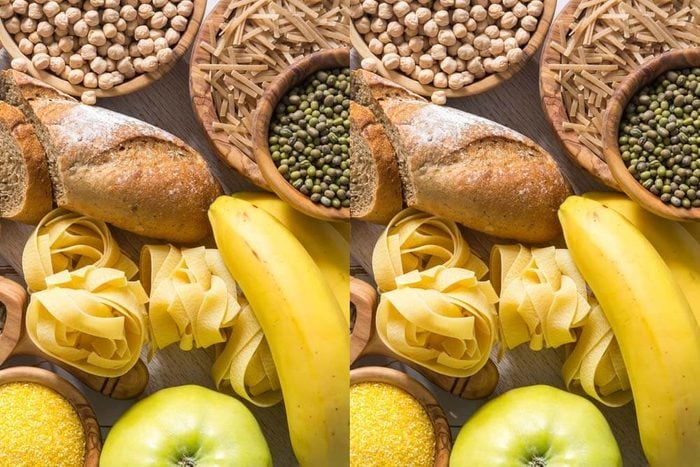

In [117]:
image = cv2.imread(img2_name)

cv2_imshow(image)

In [118]:
# cut the image in half
height, width, depth = image.shape
temp_x = int(width/2)
center_x = temp_x if width % 2 == 0 else temp_x - 1

left_image = image[:,:center_x,:]
right_image = image[:,center_x:,:]

# blur them to remove noise
left_image = cv2.GaussianBlur(left_image, (9, 9), 0)
right_image = cv2.GaussianBlur(right_image, (9, 9), 0)

In [119]:
print(left_image.shape)
print(right_image.shape)

(467, 350, 3)
(467, 350, 3)


In [120]:
# a utility function for removing noise
def erode_n_dialate(img, kernel_size, iteration_num):
  kernel = np.ones((kernel_size, kernel_size), np.uint8)
  img_erosion = cv2.erode(img, kernel, iterations=iteration_num)
  img_dilation = cv2.dilate(img_erosion, kernel, iterations=iteration_num)
  return img_dilation

### HSV filter method

Determine the difference by comparing the HSV color value. It gives a decent result but is weak against spots with little color difference.


In [121]:
# black blank image to display the difference
hsv_diff = np.zeros(left_image.shape, dtype=np.uint8)

# convert to hsv for color comparison
hsv_left = cv2.cvtColor(left_image, cv2.COLOR_BGR2HSV)
hsv_right = cv2.cvtColor(right_image, cv2.COLOR_BGR2HSV)

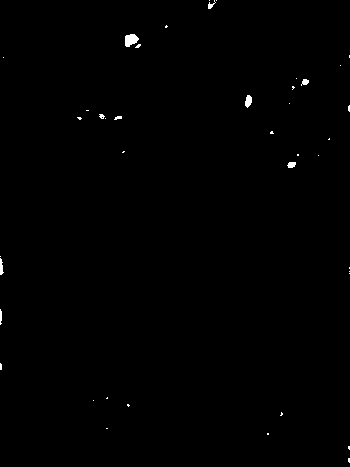

In [122]:
# the hsv range to consider the color same
acceptable_range = 30

# get the color difference
for row in range(hsv_left.shape[0]):
  for col in range(hsv_left.shape[1]):
    for color in range(2):
      left_val = hsv_left[row][col][color]
      right_val = hsv_right[row][col][color]

      # get the absolute difference (used this method because of uint8 overflow)
      diff = (left_val - right_val) if (left_val > right_val) else (right_val - left_val)

      if diff > acceptable_range:
        hsv_diff[row][col] = [255,255,255]

cv2_imshow(hsv_diff)

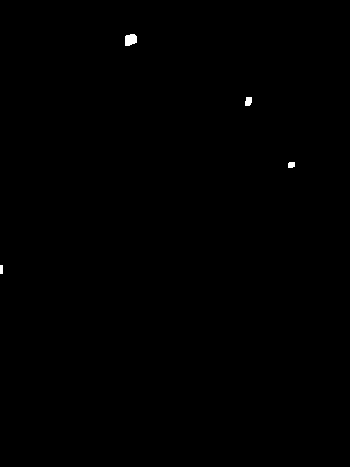

In [123]:
# clean up the image
hsv_cleaned = erode_n_dialate(img=hsv_diff, kernel_size=3, iteration_num=2)

# turn it grayscale for comparison later
hsv_cleaned = cv2.cvtColor(hsv_cleaned, cv2.COLOR_BGR2GRAY)
cv2_imshow(hsv_cleaned)

### ImageChop

Use Pillow's ImageChop method. It is a similar method to my HSV difference method, but better.

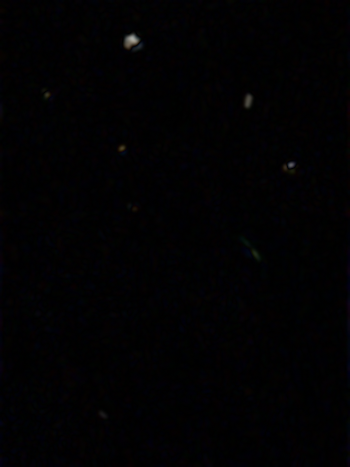

In [124]:
# import module
from PIL import Image, ImageChops

# assign images
chop_left = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
chop_left = Image.fromarray(chop_left)

chop_right = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)
chop_right = Image.fromarray(chop_right)

# finding difference
chop_diff = ImageChops.difference(chop_left, chop_right)

# showing the difference
chop_diff

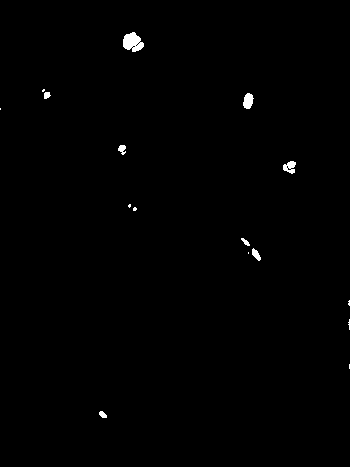

In [125]:
chop_diff = np.asarray(chop_diff)
chop_diff = cv2.cvtColor(chop_diff, cv2.COLOR_BGR2GRAY)
ret, chop_diff = cv2.threshold(chop_diff, 10, 255, cv2.THRESH_BINARY)

cv2_imshow(chop_diff)

### Structural similarity

This paper, [Image Quality Assessment: From Error Visibility to
Structural Similarity](https://ece.uwaterloo.ca/~z70wang/publications/ssim.pdf), proposes the Structural Similarity (SSIM) Index as a metric to measure image similarity using luminance, contrast, and structural information. This is an improvement over simpler methods like mean squared error comparison.

I used scikit-image's implementation of SSIM. It performs very well in different styles of images (real-life, clip art, etc.) and can detect small and faint differences as well.


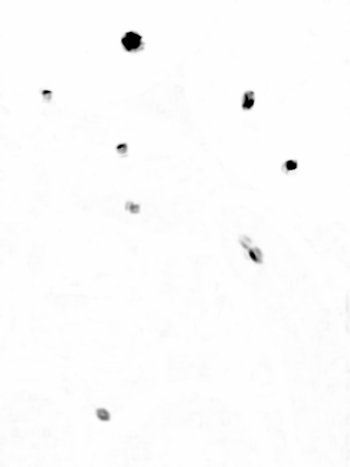

In [126]:
from skimage.metrics import structural_similarity

gray_l = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
gray_r = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)

(score, ss_diff) = structural_similarity(gray_l, gray_r, full=True)

# 0-1 float to 0-255 range-ish
ss_diff = ss_diff * 255

cv2_imshow(ss_diff)

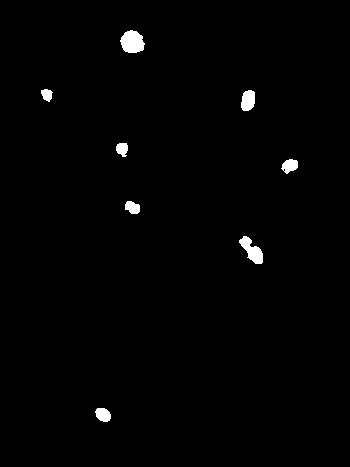

In [127]:
# threshold the best match
ret, ss_cleaned = cv2.threshold(ss_diff, 230, 255, cv2.THRESH_BINARY_INV)

# float to uint8
ss_cleaned = ss_cleaned.astype(np.uint8)

cv2_imshow(ss_cleaned)

### Combine all three

Since structural similarity performed the best, I will use that as a base and reinforce that with the result of HSV filtered image and ImageChop image.


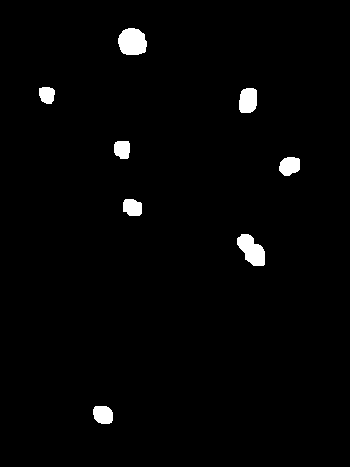

In [128]:
for row in range(ss_cleaned.shape[0]):
  for col in range(ss_cleaned.shape[1]):
      hsv_pixel = hsv_cleaned[row][col]
      chop_pixel = chop_diff[row][col]
      ss_pixel = ss_cleaned[row][col]

      # if both hsv and chop said 'yes, it's a different spot',
      # then accept it as true
      if hsv_pixel == 255 and chop_pixel == 255:
        ss_cleaned[row][col] = 255

# clump up
kernel2 = np.ones((5, 5), np.uint8)
ss_cleaned = cv2.dilate(ss_cleaned, kernel2, iterations=1)

# clean
# ss_cleaned = erode_n_dialate(ss_cleaned, 3, 1)

cv2_imshow(ss_cleaned)

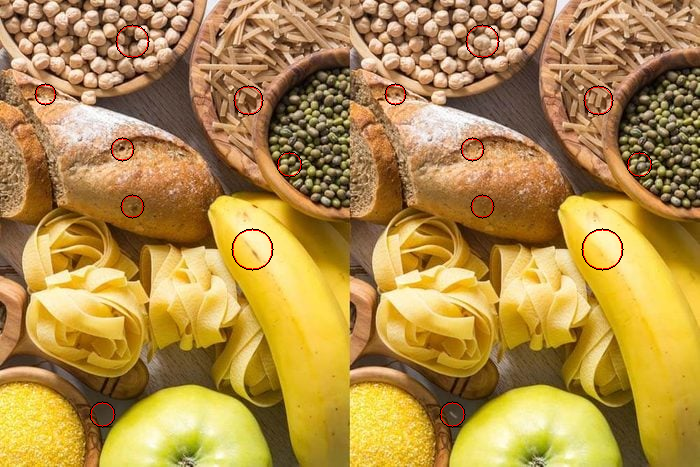

In [129]:
contours, _ = cv2.findContours(ss_cleaned,  cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

left_image_original = image[:,:center_x,:]
right_image_original = image[:,center_x:,:]

base_image_left = left_image_original.copy()
base_image_right = right_image_original.copy()

for contour in contours:
  (x,y),radius = cv2.minEnclosingCircle(contour)
  center = (int(x),int(y))
  radius = int(radius)

  # ignore noise
  if radius < 5:
    continue

  cv2.circle(base_image_left, center, radius+1, (0, 0, 255), 1)
  cv2.circle(base_image_left, center, radius+2, (0, 0, 0), 1)

  cv2.circle(base_image_right, center, radius+1, (0, 0, 255), 1)
  cv2.circle(base_image_right, center, radius+2, (0, 0, 0), 1)

two_image = np.hstack((base_image_left, base_image_right))

cv2_imshow(two_image)